# NEURON tutorial Part 2: morphologically detailed model and synapses

____
Authors of this script:

Elisabetta Iavarone @ Blue Brain Project

Werner Van Geit @ Blue Brain Project

Eilif Muller @ Blue Brain Project
____

Now that we have learned the basics on neuron compartments, mechanisms and simulations, let's move on something slightly more complex: a morphologically detailed models with synapses.

The morphology and mechanisms used in this notebook are taken from this [BluePyOpt optimisation example](https://github.com/BlueBrain/BluePyOpt/tree/master/examples/l5pc)


We will use a Layer 5 Pyramidal neuron from the rat somatosensory cortex. Let's first visualise it by using [NeuroM](https://github.com/BlueBrain/NeuroM). We can see in purple the apical dendrites, in red the basal dendrites and in blue the axon.

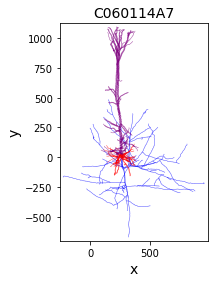

In [2]:
% matplotlib inline
import neurom
import neurom.viewer
import neuron

# Load external files
neuron.h.load_file("stdrun.hoc");

fig = neurom.viewer.draw(neurom.load_neuron('morphology/C060114A7.asc'));

To make sure we start from a clean state, we re-initialise the simulator

In [3]:
neuron.h.stdinit();

NEURON has functionality to load 3D morphologies, from different file formats, such as .swc or Neurolucida .asc. Let's load in NEURON the .asc file we've just visualised.

In [4]:
# Load NEURON functionality to load 3D morphologies
neuron.h.load_file('import3d.hoc')

# Load NEURON functionality to open Neurolucida .asc
nl = neuron.h.Import3d_Neurolucida3()
nl.input('morphology/C060114A7.asc')
morphology_importer = neuron.h.Import3d_GUI(nl, 0)
morphology_importer.instantiate(None);

In [5]:
# If you know uncomment this line you'll see a much more complex
#neuron.h.topology();

## Accessing morphological sections in Python

We can group all the morphology sections in Python lists for easier access.

In [6]:
somatic = []
apical = []
basal = []
axonal = []
all_sec = []

for sec in neuron.h.allsec():
    if 'soma' in sec.name():
        somatic.append(sec)
    if 'apic' in sec.name():
        apical.append(sec)
    if 'dend' in sec.name():
        basal.append(sec)
    if 'axon' in sec.name():
        axonal.append(sec)
    all_sec.append(sec)
    
print "The morphology has {} somatic, {} basal, {} apical, {} axonal sections.".format(len(somatic), 
                                                            len(basal), len(apical), len(axonal))
print "The total number of sections is: {}".format(len(all_sec))

The morphology has 1 somatic, 66 basal, 130 apical, 128 axonal sections.
The total number of sections is: 325


Now we can easily access the sections and insert mechanisms. We will add Na$^+$ and K$^+$ from the HH mechanism in the soma and axon and we will make the dendrites passive. 

In [7]:
# Let's set nseg in order to have chunks of section long 40 μm
for sec in all_sec:
    sec.nseg = 1 + 2 * int(sec.L / 40)
    
for sec in all_sec:
    sec.insert('hh')
    sec.Ra = 100
    sec.cm = 1
    sec.el_hh = -70
    sec.gkbar_hh = 0.0
    sec.gnabar_hh = 0.0
    
for sec in somatic:
    sec.gkbar_hh = 0.01 # in S/cm^2
    sec.gnabar_hh = 0.2 # in S/cm^2
    
for sec in axonal:
    sec.el_hh = -70
    sec.gkbar_hh = 0.01 # in S/cm^2
    sec.gnabar_hh = 0.25 # in S/cm^2

## Display membrane potential distribution in different sections

NEURON has also a graphical user interface (GUI). Let's import it now and use it explore our model.

In [9]:
from neuron import gui

# We can plot the morphology and the membrane potential from the GUI
#myshape = neuron.h.PlotShape()

#myshape.exec_menu("Shape Plot")  # Set shape plot to visualise the voltage
#myshape.exec_menu("Show Diam")   # Set shape plot appearance
#myshape.exec_menu("View = plot");

We can now apply a somatic current injection, similar to what we have seen before.

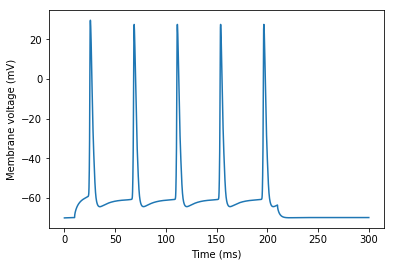

In [10]:
# Define the current protocol
iclamp = neuron.h.IClamp(.5, sec=somatic[0])
iclamp.amp = 0.5 # nA
iclamp.delay = 10 # ms
iclamp.dur = 200 # ms

def plot_time_voltage(time_array, voltage_array, show=True, label=None, constants=[]):
    import matplotlib.pyplot as plt
    import numpy
    plt.plot(time_array, voltage_array, label=label)
    for constant in constants:
        plt.plot(time_array, constant*numpy.ones(len(time_array)))
    plt.xlabel('Time (ms)')
    plt.ylabel('Membrane voltage (mV)')
    if show:
        plt.show()
        
neuron.h.tstop = 300

# Initialise arrays
time = neuron.h.Vector()
voltage = neuron.h.Vector()

# Define variable to record
time.record(neuron.h._ref_t)
voltage.record(somatic[0](.5)._ref_v);

# Define membrane potential at time 0
neuron.h.v_init = -70

neuron.h.run()

plot_time_voltage(time,voltage)

## Addying synapses

When we want our model to receive inputs from other neurons, we need to add chemical synapses. NEURON has some built-in synapses types. For example we can use the ExpSyn process. It consists of synapse with a single exponential decay of his conductance. The current generated by this synapse is:
$$I_{syn} = g_{syn}(V_{m} - E_{syn})$$

where:
$$\frac{dg_{syn}}{dt} = \frac{g_{syn}}{\tau} $$

$\tau$ is the time constant of the decay.

Every time an event arrives at the synapse, the conductance of the synapse is increased by its weight $w$ (in μS).

$$g_{syn} = g_{syn} + w $$

Let's add such synapses to the middle of each basal sections

In [11]:
# Initialise a list to contain all the synapses
basal_syn = []
for basal_sec in basal:
    expsyn = neuron.h.ExpSyn(0.5, sec=basal_sec)
    basal_syn.append(expsyn)

To stimulate the synapse we create a NetStim object. It plays the role of a spike train from a presynaptic cell. The attributes of this object specify how many presynaptic spikes, with which interval and when we want to start. The noise attribute determines the stochasticity of the process, 0 means completely regular firing.

In [12]:
netstim = neuron.h.NetStim()
netstim.interval = 5
netstim.number = 5
netstim.start = 20
netstim.noise = 0

This NetStim needs to be connected to the synapses. A NetCon object acts as the connector.


In [13]:
netcons = []
for syn in basal_syn:
    netcon = neuron.h.NetCon(netstim, expsyn)
    netcon.weight[0] = 0.2
    netcons.append(netcon)
    

And now we can run a simulation

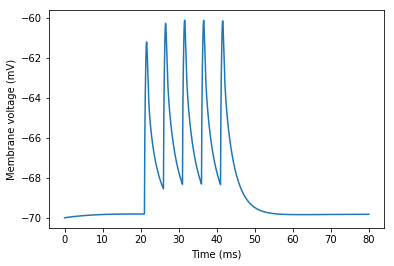

In [14]:
# Don't inject curren in the soma
iclamp.amp = 0

neuron.h.v_init = -70
neuron.h.tstop = 80
neuron.h.run()

plot_time_voltage(time, voltage)